# Libraries and Initial Methods

In [1]:
import os
import cv2
import csv
import math
import imutils
%matplotlib inline
import numpy as np
from PIL import Image
from time import sleep
from tqdm.notebook import tqdm
from scipy import ndimage as nd
from scipy.ndimage import rotate
from matplotlib import pyplot as plt

In [2]:
def showimage(myimage, figsize=[7,7], pltTitle = "", figax =[-1,-1]):
    if (myimage.ndim>2):  #This only applies to RGB or RGBA images (e.g. not to Black and White images)
        myimage = myimage[:,:,::-1] #OpenCV follows BGR order, while matplotlib likely follows RGB order
    if(figax[0] == -1):     
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = figax[0]
        ax = figax[1]
    ax.imshow(myimage, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.title(pltTitle)
    plt.show()
    
#https://www.freedomvc.com/index.php/2021/10/16/gabor-filter-in-edge-detection/

In [3]:
def partition(arr, low, high):
    i = (low-1)         # index of smaller element
    pivot = arr[high]     # pivot
 
    for j in range(low, high):
 
        # If current element is smaller than or
        # equal to pivot
        if arr[j] >= pivot:
 
            # increment index of smaller element
            i = i+1
            arr[i], arr[j] = arr[j], arr[i]
 
    arr[i+1], arr[high] = arr[high], arr[i+1]
    return (i+1)

In [4]:
def quickSort(arr, low, high):
    if len(arr) == 1:
        return arr
    if low < high:
 
        # pi is partitioning index, arr[p] is now
        # at right place
        pi = partition(arr, low, high)
 
        # Separately sort elements before
        # partition and after partition
        quickSort(arr, low, pi-1)
        quickSort(arr, pi+1, high)

In [5]:
def drawLines(image, arrayPoints, figsize=[7,7], pltTitle = ""):
    fig, ax = plt.subplots(figsize=figsize)
    for index in range(0, len(arrayPoints)):
        p1Index = index-1
        if(p1Index < 0):
            p1Index = len(arrayPoints)-1
        p1 = arrayPoints[p1Index]
        p2 = arrayPoints[index]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]])
    showimage(image, figax = [fig, ax], pltTitle = pltTitle)

In [6]:
def drawSingleLines(image, Lines, figsize=[7,7], pltTitle = ""):
    fig, ax = plt.subplots(figsize=figsize)
    
    for index in range(0, len(Lines)):
        p1 = Lines[index][0]
        p2 = Lines[index][1]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]])
    showimage(image, figax = [fig, ax], pltTitle = pltTitle)

# Step 1: Image Loading

In [7]:
def apply_filter(img, filters):
    #Normalize Image
    img = (img - img.mean()) / img.std()

    # This general function is designed to apply filters to our image
    # First create a numpy array the same size as our input image
    newimage = np.zeros_like(img)
    appliedFilters = []
    # Starting with a blank image, we loop through the images and apply our Gabor Filter
    # On each iteration, we take the highest value (super impose), until we have the max value across all filters
    # The final image is returned
    depth = -1 # remain depth same as original image
     
    for kern in filters:  # Loop through the kernels in our GaborFilter
        image_filter = np.sqrt(nd.convolve(img, np.real(kern), mode='wrap')**2 +
                   nd.convolve(img, np.imag(kern), mode='wrap')**2)
        # Using Numpy.maximum to compare our filter and cumulative image, taking the higher value (max)
        np.maximum(newimage, image_filter, newimage)        
    #newimage = np.array(newimage, dtype='int')
    newimage = np.uint8(newimage)
    return newimage

In [8]:
def create_gaborfilter():
    #https://scikit-image.org/docs/0.11.x/auto_examples/plot_gabor.html
    # This function is designed to produce a set of GaborFilters 
    # an even distribution of theta values equally distributed amongst pi rad / 180 degree
     
    filters = []
    num_filters = 16
    ksize = 15  # The local area to evaluate
    sigma = 8.0 # Larger Values produce more edges
    lambd = 13.0 #distancia entre picos
    gamma = 0.5 #com d'eliptic
    psi = 0.5  # Offset value - lower generates cleaner results
    for theta in np.arange(0, np.pi, np.pi / num_filters):  # Theta is the orientation for edge detection
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
        kern /= 1.0 * kern.sum()  # Brightness normalization
        filters.append(kern)
    return filters

In [9]:
def getGaborImage(image_og, DEBUG = False):
    #Save shape
    processSize = [500,500]
    image_bg = cv2.cvtColor(image_og.copy(), cv2.COLOR_BGR2GRAY)

    #Resize to work with it
    image_bg_res = cv2.resize(image_bg.copy(), [350, 350], interpolation= cv2.INTER_LINEAR)

    #Apply gaborFilter
    filters = create_gaborfilter()
    image_gb = apply_filter(image_bg_res, filters)
    if(DEBUG):
        showimage(image_gb, pltTitle = "1.1: Gabor Filtered")
    
    #Remove Corners
    image_gb = image_gb[int(5):int(image_gb.shape[1]-5), int(10):int(image_gb.shape[0]-5)]

    #Resize Both Pictures
    image_gb = cv2.resize(image_gb, processSize, interpolation= cv2.INTER_LINEAR)
    image_res = cv2.resize(image_og.copy(), processSize, interpolation= cv2.INTER_LINEAR)
    if(DEBUG):
        showimage(image_gb, pltTitle= "1.2: Cut picture")
    return image_gb, image_res

In [10]:
def extractBKG2(image_og, DEBUG=False):
    processSize = [500,500]
    originalSize = [image_og.shape[1], image_og.shape[0]]
    
    #Load image
    image_bg = cv2.cvtColor(image_og, cv2.COLOR_BGR2GRAY)
    
    se=cv2.getStructuringElement(cv2.MORPH_RECT , (10,10))
    image_dil=cv2.morphologyEx(image_bg, cv2.MORPH_DILATE, se)
    (thresh, blackAndWhiteImage) = cv2.threshold(image_dil, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    blackAndWhiteImage = cv2.bitwise_not(blackAndWhiteImage)
    if(DEBUG):
        showimage(cv2.bitwise_and(image_og, image_og, mask = blackAndWhiteImage), pltTitle = "1.1: No Background")
    
    #Clean image
    kernelClose = np.ones((3,3),np.uint8)
    kernelOpen = np.ones((2,2),np.uint8)
    kernelDilate = np.ones((10,10),np.uint8)

    imageMask = blackAndWhiteImage.copy()
    imageMask = cv2.morphologyEx(imageMask, cv2.MORPH_DILATE, kernelDilate)
    imageMask = cv2.morphologyEx(imageMask, cv2.MORPH_OPEN, kernelOpen)
    imageMask = cv2.morphologyEx(imageMask, cv2.MORPH_CLOSE, kernelClose)

    if(DEBUG):
        showimage(imageMask, pltTitle = "1.2: Masked Image")
        
    contours, hierarchy = cv2.findContours(imageMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    max_contour = max(contours, key=len)
    
    if(DEBUG):
        contourImage = cv2.drawContours(image_og.copy(), max_contour, -1, (0, 255, 0), 5)
        showimage(contourImage, pltTitle = "1.3: Contours")
    
    imageMask = np.zeros_like(imageMask, dtype='uint8')
    imageMask = cv2.drawContours(imageMask, [max_contour], -1, (255), thickness=-1)    
    
    imageMask=cv2.morphologyEx(imageMask, cv2.MORPH_ERODE, kernelDilate)
    
    imageMask = cv2.resize(imageMask, originalSize, interpolation= cv2.INTER_LINEAR)
    onlyPants = cv2.bitwise_and(image_og, image_og, mask = imageMask)
    if(DEBUG):
        showimage(imageMask, pltTitle = "1.7.1: Cleaned Mask")
        showimage(onlyPants, pltTitle = "1.7.2: Applied Cleaned Mask")
    return imageMask

    """
    if(DEBUG):
        showimage(imageMask, pltTitle="1.4: Mask cleaned")
    
    #Apply the new mask
    image_og = cv2.bitwise_and(image_og, image_og, mask = imageMask)
    if(DEBUG):
        showimage(image_og, pltTitle = "1.5: Only Interest")
    
    image_res = cv2.resize(image_og.copy(), None, fx=factor, fy=factor, interpolation= cv2.INTER_LINEAR)
    imageMask_res = cv2.resize(imageMask.copy(), None, fx=factor, fy=factor, interpolation= cv2.INTER_LINEAR)
    return image_og, image_res, imageMask_res, angle
    """

In [11]:
def extractBKG1(image_og, DEBUG=False):
    originalSize = [image_og.shape[1], image_og.shape[0]]
    
    #Get gabor picture, and resized Picture
    image_gb, image_res = getGaborImage(image_og, DEBUG)
        
    se=cv2.getStructuringElement(cv2.MORPH_RECT , (10,10))
    image_dil=cv2.morphologyEx(image_gb, cv2.MORPH_DILATE, se)
    (thresh, blackAndWhiteImage) = cv2.threshold(image_dil, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    if(DEBUG):
        showimage(cv2.bitwise_and(image_res, image_res, mask = blackAndWhiteImage), pltTitle = "1.3: Simplified Picture")
    
    #Clean image
    kernelClose = np.ones((3,3),np.uint8)
    imageMask = blackAndWhiteImage.copy()
    imageMask = cv2.morphologyEx(imageMask, cv2.MORPH_CLOSE, kernelClose)

    if(DEBUG):
        showimage(imageMask, pltTitle = "1.4: Masked Image")
        
    contours, hierarchy = cv2.findContours(imageMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    max_contour = max(contours, key=len)
    
    if(DEBUG):
        contourImage = cv2.drawContours(image_res.copy(), max_contour, -1, (0, 255, 0), 5)
        showimage(contourImage, pltTitle = "1.5: Contours")
    
    imageMask = np.zeros_like(imageMask, dtype='uint8')
    imageMask = cv2.drawContours(imageMask, [max_contour], -1, (255), thickness=-1)    
    
    imageMask = cv2.morphologyEx(imageMask, cv2.MORPH_ERODE, se)
    if(DEBUG):
        showimage(imageMask, pltTitle="1.6: Mask cleaned")   
    
    imageMask = cv2.resize(imageMask, originalSize, interpolation= cv2.INTER_LINEAR)
    onlyPants = cv2.bitwise_and(image_og, image_og, mask = imageMask)
    if(DEBUG):
        showimage(imageMask, pltTitle = "1.7.1: Cleaned Mask")
        showimage(onlyPants, pltTitle = "1.7.2: Applied Cleaned Mask")
    return imageMask

In [12]:
def extractBKGGrab(image_og, DEBUG=False):
    originalSize = [image_og.shape[1], image_og.shape[0]]
    image_gb, image_res = getGaborImage(image_og, DEBUG)

    #Binarize Picture
    se=cv2.getStructuringElement(cv2.MORPH_RECT , (5,5))
    image_dil=cv2.morphologyEx(image_gb, cv2.MORPH_DILATE, se)
    (thresh, blackAndWhiteImage) = cv2.threshold(image_dil, 7.5, 255, cv2.THRESH_BINARY)
    if(DEBUG):
        showimage(blackAndWhiteImage, pltTitle = "1.3: Binarized Picture")
    
    #Single object on screen
    imageMask = blackAndWhiteImage.copy()
    contours, hierarchy = cv2.findContours(imageMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if(len(contours) <= 0):
        return imageMask
    max_contour = max(contours, key=len)
    
    imageMask = np.zeros_like(imageMask, dtype='uint8')
    imageMask = cv2.drawContours(imageMask, [max_contour], -1, (255), thickness=-1)   
    se=cv2.getStructuringElement(cv2.MORPH_RECT , (10,10))
    imageMask=cv2.morphologyEx(imageMask, cv2.MORPH_DILATE, se)
    if(DEBUG):
        showimage(imageMask, pltTitle = "1.4.1: Single Pants Mask")
        showimage(cv2.bitwise_and(image_res, image_res, mask = imageMask), pltTitle = "1.4.2: Applied Mask")
    
    #Transform Mask for Grab Cut
    mask = np.where((imageMask==255),3,0).astype('uint8') 
    bgdModel = np.zeros((1,65),np.float64) 
    fgdModel = np.zeros((1,65),np.float64) 
    rect = [0,0,0,0]
    new_mask, fg, bg = cv2.grabCut(image_res,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)
    if(DEBUG):
        showimage(new_mask, pltTitle="1.5.1: Extracted Mask with Grab Cut")
    
    mask2 = np.where((new_mask==2)|(new_mask==0),0,1).astype('uint8') 
    if(DEBUG):
        showimage(cv2.bitwise_and(image_res, image_res, mask = mask2), pltTitle = "1.5.2: Applied Grab Cut Mask")
                  
    #Cleaning Mask
    se=cv2.getStructuringElement(cv2.MORPH_RECT , (5,5))
    mask2 = cv2.morphologyEx(mask2, cv2.MORPH_ERODE, se)
    contours, hierarchy = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if(len(contours) <= 0):
        return imageMask
    max_contour = max(contours, key=len)
    
    #Applying mask
    imageMask = np.zeros_like(imageMask, dtype='uint8')
    imageMask = cv2.drawContours(imageMask, [max_contour], -1, (255), thickness=-1)       
    imageMask = cv2.resize(imageMask, originalSize, interpolation= cv2.INTER_LINEAR)
    onlyPants = cv2.bitwise_and(image_og, image_og, mask = imageMask)
    if(DEBUG):
        showimage(imageMask, pltTitle = "1.6.1: Cleaned Mask")
        showimage(onlyPants, pltTitle = "1.6.2: Applied Cleaned Mask")
    return imageMask

# Step 2: Pant detection

In [13]:
def checkAngle(p1,p2,p3, threshold, drawQuiver = False):
    p1 = p1.astype(float)
    p2 = p2.astype(float)
    p3 = p3.astype(float)
    
    line1 = p2-p1
    line2 = p3-p2
    line1mag = np.linalg.norm(line1)
    line2mag = np.linalg.norm(line2)
    if(line1mag <= 0.1 or line2mag <= 0.1):
        return False
        
    line1 = line1/line1mag
    line2 = line2/line2mag
    
    dot = np.dot(line1, line2)
    
    if(drawQuiver):
        print(dot)
        fig, ax = plt.subplots(figsize=[7,7])
        plt.quiver([0, 0], [0, 0], [line1[0], line2[0]], [line1[1], line2[1]], angles='xy', scale_units='xy', scale=1)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.show()
    if(dot <= threshold):
        return True
    else: 
        return False

In [14]:
def extractPantsOutline(image_og, imageMask, minimumDistance, blockSize = 23, ksize = 9, k = 0.1, DEBUG = False, quiv = False):
    targetSize = [500, 500]
    originalSize = [image_og.shape[1], image_og.shape[0]]
    imageMask = cv2.resize(imageMask, targetSize, interpolation= cv2.INTER_LINEAR)
    image_res = cv2.resize(image_og, targetSize, interpolation= cv2.INTER_LINEAR)

    #Preprocessing       
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened = cv2.filter2D(imageMask, -1, kernel) #Sharpen image
    kernelClose = np.ones((7,7),np.uint8)
    sharpened = cv2.morphologyEx(sharpened, cv2.MORPH_CLOSE, kernelClose)
    if(DEBUG):
        showimage(sharpened, pltTitle = "2.1: Sharpen the image")
        
    #Get corners through Harris
    operatedImage = np.uint8(sharpened)
    dest = cv2.cornerHarris(operatedImage, blockSize, ksize, k) #Input parameters
    dest = cv2.dilate(dest, None) #Get corners
    if(DEBUG):
        showimage(dest, pltTitle = "2.2: Find corners")
        
    #Making Blobs out of those corners
    corners = np.zeros_like(dest)
    corners[dest>0.001*dest.max()] = [1.]
    kernelClose = np.ones((3,3),np.uint8)
    corners = cv2.morphologyEx(corners, cv2.MORPH_CLOSE, kernelClose)
    if(DEBUG):
        showimage(corners, pltTitle = "2.3: Get blobs of corners")
    
    #Transform corner type
    corners = corners.astype(np.uint8)

    #Getting centers of corners
    cornerContours, hierarchy = cv2.findContours(corners, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    centers = np.zeros_like(corners)
    cornerPoints = []
    for i in cornerContours:
        M = cv2.moments(i)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            cv2.circle(centers, (cx, cy), 4, (1), -1)
            cornerPoints.append([cx,cy])
    if(DEBUG):
        imageWithCenters = image_res.copy()
        cornerCopy = np.array(centers.copy())
        imageWithCenters[centers>0.01*centers.max()] = [0,0,255]
        showimage(imageWithCenters, pltTitle = "2.4: Visualized Blobs")
        
    #Get Contours of image
    contours, hierarchy = cv2.findContours(imageMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if(len(contours) <= 0):
        return [], False
    pantsContour = max(contours, key=len)
    if(DEBUG):
        contourImage = cv2.drawContours(image_res.copy(), pantsContour, -1, (0, 255, 0), 5)
        showimage(contourImage, pltTitle = "2.5: Contours")
        
    ##Possible millora aplicant minAreaRect
    
    #Sort Corners
    sortedCorners = []  #Non sorted
    for point in pantsContour:
        point = point[0]
        for corner in cornerPoints:
            distance = np.linalg.norm(corner-point) #gets length
            if distance < minimumDistance:
                sortedCorners.append(corner)
                cornerPoints.remove(corner)
                break
    if(DEBUG):
        drawLines(image_res, sortedCorners, pltTitle = "2.6: Initial Corners")

    #Remove unnecessary corners
    for iteration in range(0, 3):
        finalCorners = []
        for index in range(0, len(sortedCorners)):
            p1Ind = index-2
            if(p1Ind < 0):
                p1Ind = len(sortedCorners)-2
            p2Ind = index-1
            if(p2Ind < 0):
                p2Ind = len(sortedCorners)-1

            p1 = np.array(sortedCorners[p1Ind])
            p2 = np.array(sortedCorners[p2Ind])
            p3 = np.array(sortedCorners[index])
            if(checkAngle(p1, p2, p3, 0.7, drawQuiver = quiv)):
                finalCorners.append(sortedCorners[p2Ind])
        sortedCorners = finalCorners
        if(len(sortedCorners) <= 7):
            break
    
    #Final result
    xDif = originalSize[0]/targetSize[0]
    yDif = originalSize[1]/targetSize[1]
    scaledCorners = []
    for index in range(0,len(finalCorners)):
        scaledCorners.append([int(finalCorners[index][0]*xDif),int(finalCorners[index][1]*yDif)])
    scaledCorners = np.array(scaledCorners)
    
    if(DEBUG):
        drawLines(image_og, scaledCorners, pltTitle = "2.7: Simplified Contours")   
    
    corners = len(scaledCorners)
    if(corners == 7):
         return scaledCorners, True
    else:
         return scaledCorners, False

# Step 3: Focusing

In [15]:
def findSharingPoint(Line1, Line2):
    if(np.array_equal(Line1[0],Line2[0])):
        return Line1[0]
    else: 
        if(np.array_equal(Line1[1],Line2[0])):
            return Line1[1]
        else:
            return Line2[1]

In [16]:
def findIntersection(Line1, Line2, reesizeFactor = 0.2):
        A = Line1[0]*reesizeFactor
        B = Line1[1]*reesizeFactor
        
        C = Line2[0]*reesizeFactor
        D = Line2[1]*reesizeFactor
        a1 = B[1] - A[1];
        b1 = A[0] - B[0];
        c1 = a1 * (A[0]) + b1 * (A[1]);
  
        a2 = D[1] - C[1];
        b2 = C[0] - D[0];
        c2 = a2 * (C[0]) + b2 * (C[1]);
  
        determinant = a1 * b2 - a2 * b1;
  
        if determinant == 0:
            print("Parallel")
        else:
            x = int((b2 * c1 - b1 * c2) / determinant);
            y = int((a1 * c2 - a2 * c1) / determinant);
            return [x/reesizeFactor,y/(reesizeFactor)];

In [17]:
def getTopPants(image_og, imageMask, corners, DEBUG = False):
    pants = cv2.bitwise_and(image_og, image_og, mask = imageMask)
    #We get distances between all consecutive points
    distances = []
    for index1 in range(0, len(corners)):
        index0 = index1-1
        if(index0 < 0):
            index0 = len(corners)-1

        p1 = np.array(corners[index1])
        p0 = np.array(corners[index0])

        distance = np.linalg.norm(p0-p1)
        distances.append([distance, [corners[index0],corners[index1]]])
    
    #The list gets sorted
    quickSort(distances,0, len(distances)-1)
    
    #Get the two longest lines
    Line1 = distances[0][1]
    Line2 = distances[1][1]
    if(DEBUG):
        Lines = [Line1, Line2]
        drawSingleLines(pants, Lines, pltTitle = "3.1: Get longest lines")
        
    #Get the waist line
    WaistPoints = distances[4][1]
    
    #We find the crotch point
    crotchPoint = findSharingPoint(distances[2][1], distances[3][1])
    WaistLine = np.array(WaistPoints[1])-np.array(WaistPoints[0])
    if(DEBUG):
        Lines = [Line1, Line2, WaistPoints]
        drawSingleLines(pants, Lines, pltTitle = "3.2: Get waist line")
        
    #Create crotch line in parallel to waistLine
    CrotchLine = [crotchPoint, crotchPoint + WaistLine]
    
    #Find intersection point between crotch line and longest one
    intersection1 = findIntersection(Line1, CrotchLine)
    intersection2 = findIntersection(Line2, CrotchLine)
    if(DEBUG):
        Lines = [[intersection1, crotchPoint], [intersection2, crotchPoint]]
        drawSingleLines(pants, Lines, pltTitle = "3.3: Get intersection lines with crotch")
        
    #New points with crotch and longest lines
    corner1 = findIntersection(Line1, WaistPoints)
    corner2 = findIntersection(Line2, WaistPoints)
    
    #Order all the points
    FinalPoints = np.float32([corner1, intersection1, intersection2, corner2])
    if(DEBUG):
        drawLines(pants, FinalPoints, pltTitle = "3.4: Final set of points on original Image")
        
    #New size
    targetCoordinates = np.float32([[0,0], [0,255], [255,255], [255,0]])
        
    #Wrap image to fit
    matrix = cv2.getPerspectiveTransform(FinalPoints, targetCoordinates)
    result = cv2.warpPerspective(pants, matrix, (255, 255))
    if(DEBUG):
        showimage(result, pltTitle = "3.5: Warped image")
    return result

# Current process

In [46]:
PictureRoute = r'Data\NewDataset\Reverse_Down\1652615425089.jpg'
x1 = 700
x2 = 3250
y1 = 0
y2 = 50000
cutMatrix = [x1,x2,y1,y2]

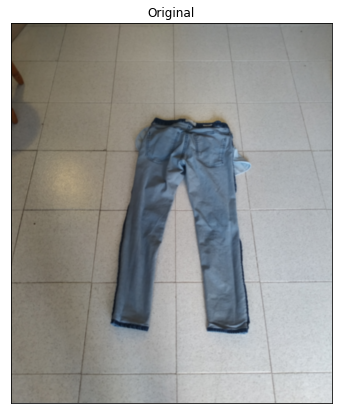

In [47]:
image = cv2.imread(PictureRoute)
image = image[int(cutMatrix[2]):int(cutMatrix[3]), int(cutMatrix[0]):int(cutMatrix[1])]
showimage(image, pltTitle='Original')

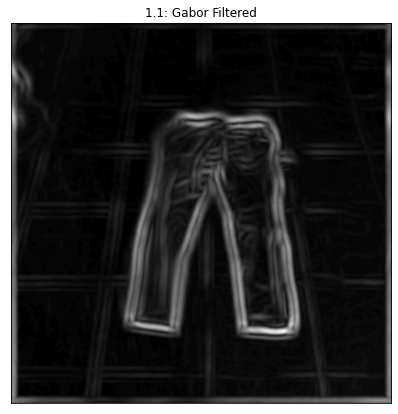

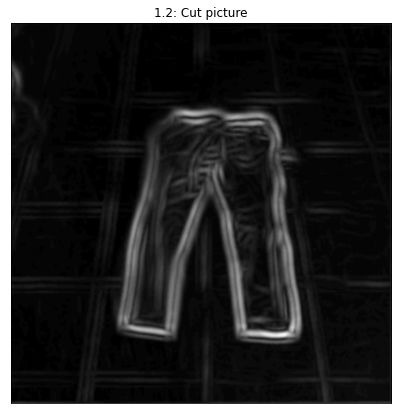

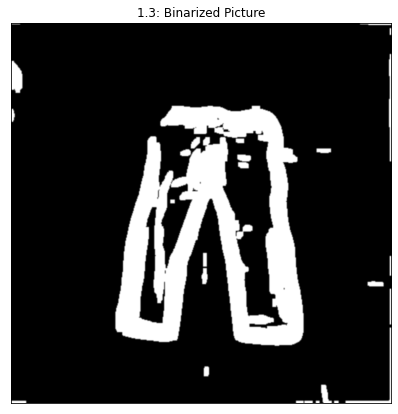

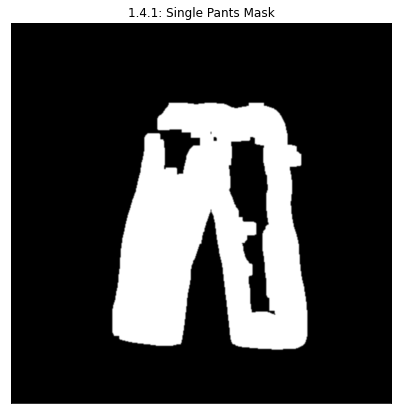

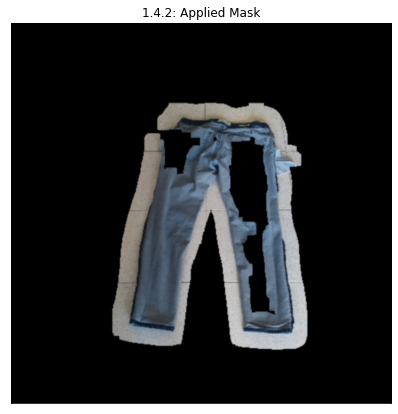

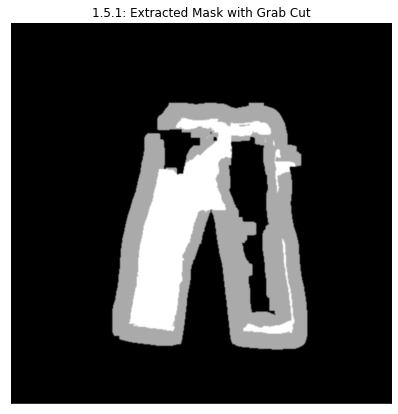

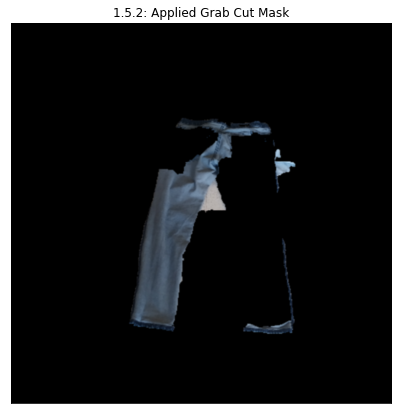

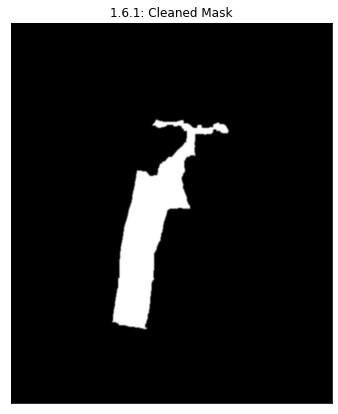

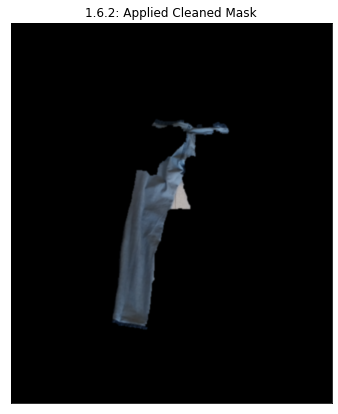

In [48]:
imageMask = extractBKGGrab(image,DEBUG = True)

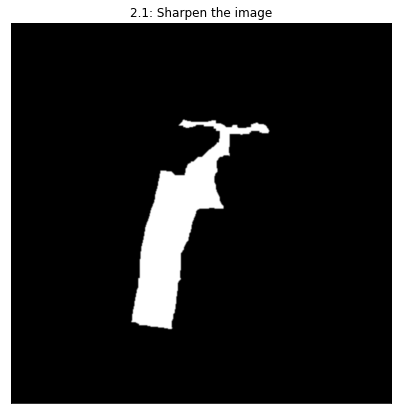

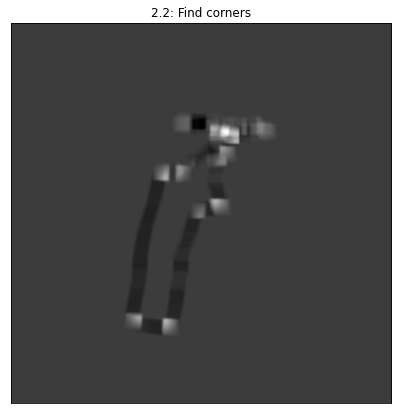

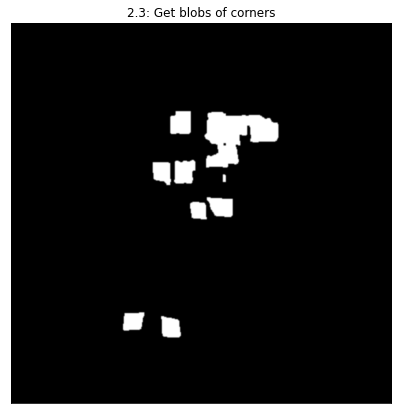

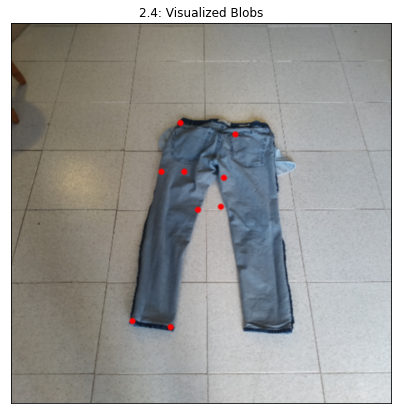

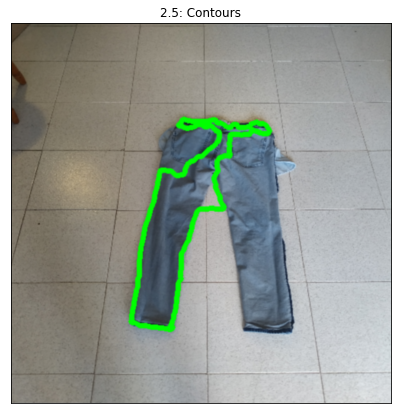

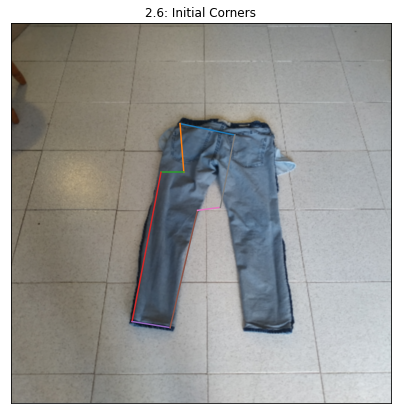

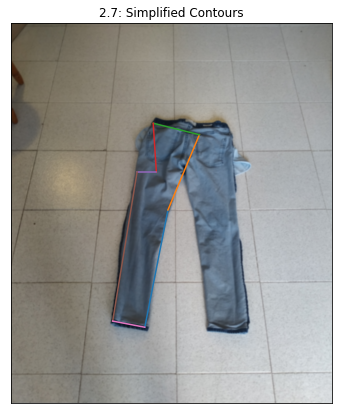

In [49]:
corners, arePants = extractPantsOutline(image,imageMask, 4, DEBUG = True)

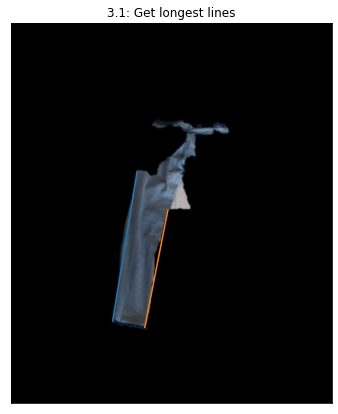

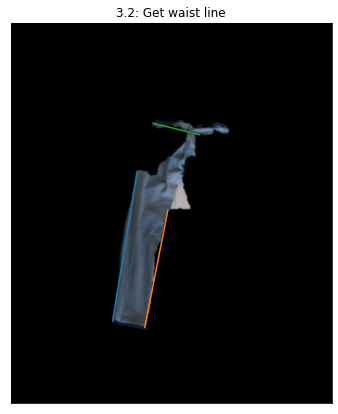

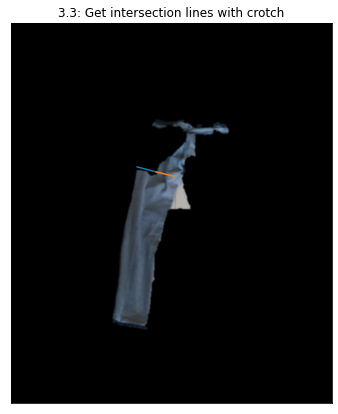

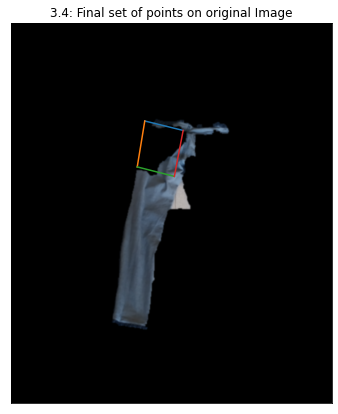

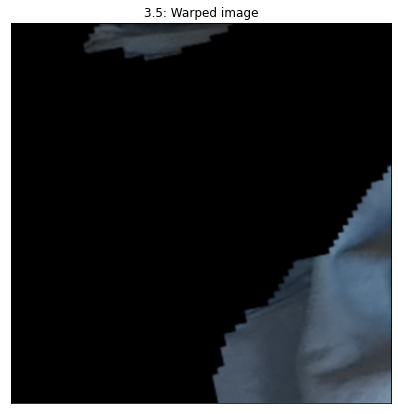

In [50]:
if(arePants):
    result = getTopPants(image, imageMask, corners, DEBUG = True)

In [27]:
def pantsCheck0(image):
    imageMask = extractBKGGrab(image)
    corners, arePants = extractPantsOutline(image,imageMask, 4)
    if(arePants):
        result = getTopPants(image, imageMask, corners)
        return result, True
    return image, False

In [28]:
def pantsCheck1(image):
    imageMask = extractBKG1(image)
    corners, arePants = extractPantsOutline(image,imageMask, 4)
    if(arePants):
        result = getTopPants(image, imageMask, corners)
        return result, True
    return image, False

In [29]:
def pantsCheck2(image):
    imageMask = extractBKG2(image)
    corners, arePants = extractPantsOutline(image,imageMask, 4)
    if(arePants):
        result = getTopPants(image, imageMask, corners)
        return result, True
    return image, False

# Saving images

In [30]:
def saveImage(image, baseRoot, folderName, iPath, fileName):
    name = 'P_'+str(iPath)+"_" + fileName
    if not os.path.exists(baseRoot):
        os.mkdir(baseRoot)
    finalDest = os.path.join(baseRoot,folderName)
    if not os.path.exists(finalDest):
        os.mkdir(finalDest)
    finalDest = os.path.join(finalDest,name)
    cv2.imwrite(finalDest, image)
    return finalDest

In [31]:
ReverseDownPath = r'Data\NewDataset\Reverse_Down'
ReverseUpPath = r'Data\NewDataset\Reverse_Up'
RightDownPath = r'Data\NewDataset\Right_Down'
RightUpPath = r'Data\NewDataset\Right_Up'
Labels = ['file','label']
AllPaths = [ReverseDownPath,ReverseUpPath,RightDownPath,RightUpPath]

finalRoute = r'Data\TrimmedPants3'
finalCSVName = r'Data\TrimmedPants3\pants_dataset.csv'
filesCSV = []

In [40]:
for iPath, path in enumerate(AllPaths):
    if(iPath == 0):
        pathName = "Reverse_Down"
    elif(iPath == 1):
        pathName = "Reverse_Up"
    elif(iPath == 2):
        pathName = "Right_Down"
    else:
        pathName = "Right_Up"
    x1 = 700
    x2 = 3250
    y1 = 0
    y2 = 50000
    cutMatrix = [x1,x2,y1,y2]
    for files in os.listdir(path):
        finalPath = os.path.join(path, files)
        image = cv2.imread(finalPath)
        image = image[int(cutMatrix[2]):int(cutMatrix[3]), int(cutMatrix[0]):int(cutMatrix[1])]
        pantsPic, arePants = pantsCheck0(image)
        if(arePants == False):
            pantsPic, arePants = pantsCheck1(image)
        if(arePants == False):
            pantsPic, arePants = pantsCheck2(image)
        if(arePants != False):
            route = saveImage(pantsPic,finalRoute, pathName, iPath, files)
            filesCSV.append([route,pathName])
        else:
            print("Issue with " + files)

Issue with 1652555728229.jpg
Issue with 1652615425053.jpg
Issue with 1652615425080.jpg
Issue with 1652615425109.jpg
Issue with 1652615425281.jpg


In [ ]:
ReverseDownPath = r'Data\TrimmedPants\Reverse_Down'
ReverseUpPath = r'Data\TrimmedPants\Reverse_Up'
RightDownPath = r'Data\TrimmedPants\Right_Down'
RightUpPath = r'Data\TrimmedPants\Right_Up'
Labels = ['file','label']
AllPaths = [ReverseDownPath,ReverseUpPath,RightDownPath,RightUpPath]

finalCSVName = r'Data\TrimmedPants\pants_dataset.csv'
filesCSV = []

In [ ]:
filesCSV = []
for iPath, path in enumerate(AllPaths):
    if(iPath == 0):
        pathName = "Reverse_Down"
    elif(iPath == 1):
        pathName = "Reverse_Up"
    elif(iPath == 2):
        pathName = "Right_Down"
    else:
        pathName = "Right_Up"
    
    for files in os.listdir(path):
        finalPath = os.path.join(path, files)
        filesCSV.append([finalPath,pathName])

In [ ]:
with open(finalCSVName, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(Labels) 
    for row in filesCSV:
        csvwriter.writerow(row)

62

aplicant grab
66

augmentant una coseta
70

augmentant mes

# Testing

In [ ]:
def pantsCheck0(image):
    imageMask = extractBKGGrab(image)
    corners, arePants = extractPantsOutline(image,imageMask, 4)
    if(arePants):
        result = getTopPants(image, imageMask, corners)
        return result, True
    return image, False

In [ ]:
ReverseDownPath = r'Data\NewDataset\Reverse_Down'
ReverseUpPath = r'Data\NewDataset\Reverse_Up'
RightDownPath = r'Data\NewDataset\Right_Down'
RightUpPath = r'Data\NewDataset\Right_Up'
Labels = ['file','label']
AllPaths = [ReverseDownPath,ReverseUpPath,RightDownPath,RightUpPath]

In [ ]:
def redoDebug(image):
    imageMask = extractBKGGrab(image, DEBUG = True)
    corners, arePants = extractPantsOutline(image,imageMask, 4, DEBUG = True)
    if(arePants):
        result = getTopPants(image, imageMask, corners, DEBUG = True)

In [ ]:
x1 = 700
x2 = 3250
y1 = 0
y2 = 50000
cutMatrix = [x1,x2,y1,y2]
for iPath, path in enumerate(AllPaths):
    if(iPath == 0):
        pathName = "Reverse_Down"
    elif(iPath == 1):
        pathName = "Reverse_Up"
    elif(iPath == 2):
        pathName = "Right_Down"
    else:
        pathName = "Right_Up"
    for files in os.listdir(path):
        finalPath = os.path.join(path, files)
        image = cv2.imread(finalPath)
        image = image[int(cutMatrix[2]):int(cutMatrix[3]), int(cutMatrix[0]):int(cutMatrix[1])]
        pantsPic, arePants = pantsCheck0(image)
        if(arePants == False):
            print("Issue with " + files)
            redoDebug(image)
        else:
            print("Fine with " + files)
            showimage(pantsPic)